<a href="https://colab.research.google.com/github/LetMeIK/Simple_DL/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# модули библиотеки PyTorch
import torch
from torchvision import datasets, transforms

In [2]:
# Загрузка Датасета
train_data = datasets.MNIST(root="./mnist_data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root="./mnist_data", train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 161578923.57it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 112684366.35it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 46734995.69it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 18212742.61it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
# в тренировочную выборку отнесем 80% всех картинок
train_size = int(len(train_data) * 0.8)
# в валидационную — остальные 20%
val_size = len(train_data) - train_size

train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

In [5]:
train_data, val_data, test_data

(<torch.utils.data.dataset.Subset at 0x7e9334116e60>,
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./mnist_data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [6]:
# Разбиение на батчи
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

In [7]:
# модуль, где определены слои для нейронных сетей
import torch.nn as nn
# модуль, где определены активации для слоев нейронных сетей
import torch.nn.functional as F

In [8]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.fc_in = nn.Linear(28*28, 256)
        self.fc_out = nn.Linear(256, 10)

    def forward(self, x):
        # forward pass сети

        # переводим входной объект из картинки в вектор
        x = self.flatten(x)
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = F.relu(self.fc_in(x))
        # умножение на матрицу весов 2 слоя и применение функции активации
        x = self.fc_out(x)
        return x

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
model = SimpleNet().to(device)

In [11]:
# функция потерь
loss_fn = torch.nn.CrossEntropyLoss()

# оптимизатор
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
from sklearn.metrics import accuracy_score

def evaluate(model, dataloader, loss_fn):

    y_pred_list = []
    y_true_list = []
    losses = []

    # проходимся по батчам даталоадера
    for i, batch in enumerate(tqdm(dataloader)):

        # так получаем текущий батч
        X_batch, y_batch = batch

        # выключаем подсчет любых градиентов
        with torch.no_grad():

            # получаем ответы сети на батч
            logits = model(X_batch.to(device))

            # вычисляем значение лосс-функции на батче
            loss = loss_fn(logits, y_batch.to(device))
            loss = loss.item()

            # сохраняем лосс на текущем батче в массив
            losses.append(loss)

            # для каждого элемента батча понимаем,
            # к какому классу от 0 до 9 отнесла его сеть
            y_pred = torch.argmax(logits, dim=1)

        # сохраняем в массивы правильные ответы на текущий батч
        # и ответы сети на текущий батч
        y_pred_list.extend(y_pred.cpu().numpy())
        y_true_list.extend(y_batch.numpy())

    # считаем accuracy между ответам сети и правильными ответами
    accuracy = accuracy_score(y_pred_list, y_true_list)

    return accuracy, np.mean(losses)

In [12]:
def train(model, loss_fn, optimizer, n_epoch):

    model.train(True)

    data = {
        'acc_train': [],
        'loss_train': [],
        'acc_val': [],
        'loss_val': []
    }

    # цикл обучения сети
    for epoch in tqdm(range(n_epoch)):

        for i, batch in enumerate(tqdm(train_loader)):

            # так получаем текущий батч картинок и ответов к ним
            X_batch, y_batch = batch

            # forward pass (получение ответов сети на батч картинок)
            logits = model(X_batch.to(device))

            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(logits, y_batch.to(device))

            optimizer.zero_grad() # обнуляем значения градиентов оптимизаторв
            loss.backward() # backpropagation (вычисление градиентов)
            optimizer.step() # обновление весов сети

        # конец эпохи, валидируем модель
        print('On epoch end', epoch)

        acc_train_epoch, loss_train_epoch = evaluate(model, train_loader, loss_fn)
        print('Train acc:', acc_train_epoch, 'Train loss:', loss_train_epoch)

        acc_val_epoch, loss_val_epoch = evaluate(model, val_loader, loss_fn)
        print('Val acc:', acc_val_epoch, 'Val loss:', loss_val_epoch)


        data['acc_train'].append(acc_train_epoch)
        data['loss_train'].append(loss_train_epoch)
        data['acc_val'].append(acc_val_epoch)
        data['loss_val'].append(loss_val_epoch)

    return model, data

In [15]:
 # Обучение модели

model, data = train(model, loss_fn, optimizer, n_epoch=3)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

On epoch end 0


  0%|          | 0/750 [00:00<?, ?it/s]

Train acc: 0.9718333333333333 Train loss: 0.09711038642873367


  0%|          | 0/750 [00:00<?, ?it/s]

Val acc: 0.9718333333333333 Val loss: 0.09711038652062416


  0%|          | 0/750 [00:00<?, ?it/s]

On epoch end 1


  0%|          | 0/750 [00:00<?, ?it/s]

Train acc: 0.9805833333333334 Train loss: 0.06899307546267906


  0%|          | 0/750 [00:00<?, ?it/s]

Val acc: 0.9805833333333334 Val loss: 0.06899307555829486


  0%|          | 0/750 [00:00<?, ?it/s]

On epoch end 2


  0%|          | 0/750 [00:00<?, ?it/s]

Train acc: 0.9862083333333334 Train loss: 0.04857543409305314


  0%|          | 0/750 [00:00<?, ?it/s]

Val acc: 0.9862083333333334 Val loss: 0.04857543378074964


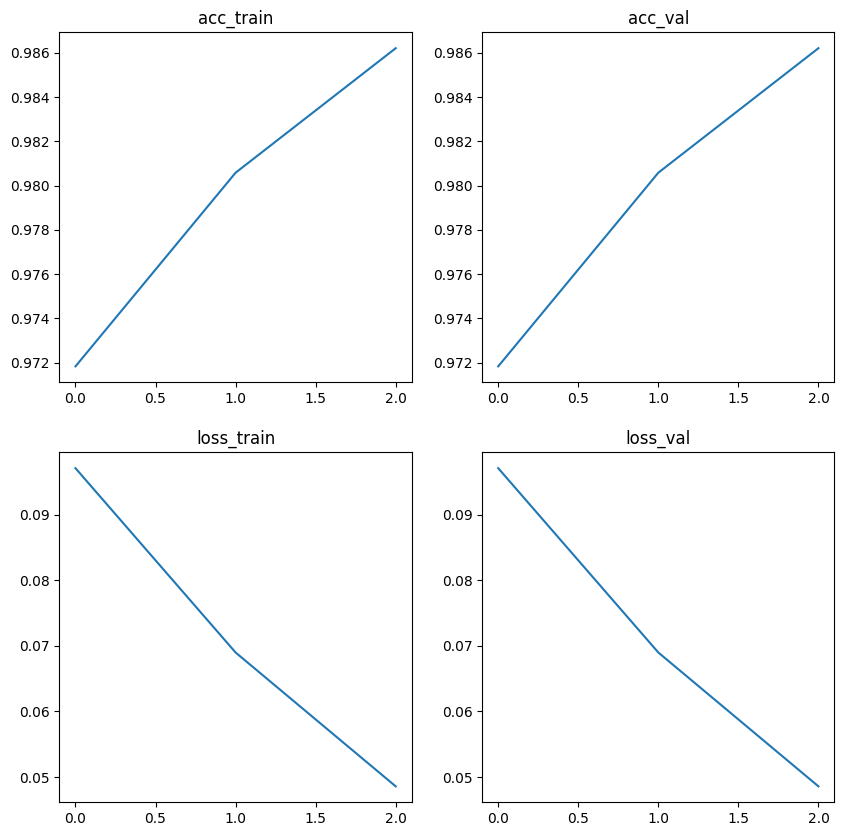

In [16]:
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ox = list(range(3))

axes[0][0].plot(ox, data['acc_train'])
axes[0][0].title.set_text('acc_train')

axes[0][1].plot(ox, data['acc_val'])
axes[0][1].title.set_text('acc_val')

axes[1][0].plot(ox, data['loss_train'])
axes[1][0].title.set_text('loss_train')

axes[1][1].plot(ox, data['loss_val'])
axes[1][1].title.set_text('loss_val')

plt.show()

In [17]:
from sklearn.metrics import accuracy_score

def evaluate(model, dataloader, loss_fn):

    y_pred_list = []
    y_true_list = []
    losses = []

    # проходимся по батчам даталоадера
    for i, batch in enumerate(tqdm(dataloader)):

        # так получаем текущий батч
        X_batch, y_batch = batch

        # выключаем подсчет любых градиентов
        with torch.no_grad():

            # получаем ответы сети на батч
            logits = model(X_batch.to(device))

            # вычисляем значение лосс-функции на батче
            loss = loss_fn(logits, y_batch.to(device))
            loss = loss.item()

            # сохраняем лосс на текущем батче в массив
            losses.append(loss)

            # для каждого элемента батча понимаем,
            # к какому классу от 0 до 9 отнесла его сеть
            y_pred = torch.argmax(logits, dim=1)

        # сохраняем в массивы правильные ответы на текущий батч
        # и ответы сети на текущий батч
        y_pred_list.extend(y_pred.cpu().numpy())
        y_true_list.extend(y_batch.numpy())

    # считаем accuracy между ответам сети и правильными ответами
    accuracy = accuracy_score(y_pred_list, y_true_list)

    return accuracy, np.mean(losses)

In [18]:
evaluate(model, train_loader, loss_fn)

  0%|          | 0/750 [00:00<?, ?it/s]

(0.9862083333333334, 0.04857543373356263)

In [19]:
evaluate(model, test_loader, loss_fn)

  0%|          | 0/157 [00:00<?, ?it/s]

(0.976, 0.07809125971320459)